In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In /home/chris/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/chris/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/chris/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
#file = "../code/data/as-skitter.lpairs.space.csv"
#file = "../code/data/soc-slashdot.ghpairs.space.csv"
file = "../code/cmake-build-release/soc-slashdot.ghpairs.space.csv"
#file = "../code/data/soc-slashdot.lpairs.space.csv"
df = pd.read_csv(file)

# add new columns for lastLayer w/o inter
for prefix in ['nodes','edges','dfsNodes','dfsEdges']:
    for dir in ['S','T']:
        newName = f"{prefix}InLastLayer{dir}\inter"
        lastLayer = f"{prefix}InLastLayer{dir}"
        intersection = prefix+"InInter"
        if prefix[0:3]=='dfs' and dir=='T':
            df[newName] = [0]*len(df)
        else:
            df[newName] = df[lastLayer] - df[intersection]

# add flow column
df['flow'] = df['flowBefore'].shift(-1, fill_value=0) - df['flowBefore']
df['flow'] = df['flow'].clip(lower=0)

print(f'read {file} with {len(df)} rows')

read ../code/cmake-build-release/soc-slashdot.ghpairs.space.csv with 386880 rows


In [3]:
colors = {
    'BeforeLastLayerS': '#56B4E9', 
    'InLastLayerS\inter': '0.75', 
    'InInter': '#D55E00', 
    'InLastLayerT\inter': '0.75', 
    'BeforeLastLayerT': '#009E73',
}
    
allEdges = [
    'edgesBeforeLastLayerS',
    'edgesInLastLayerS\inter',
    'edgesInInter',
    'edgesInLastLayerT\inter',
    'edgesBeforeLastLayerT'
]
bfsEdges = ['edgesBeforeLastLayerS', 'edgesBeforeLastLayerT']
dfsEdges = [
    'dfsEdgesBeforeLastLayerS',
    #'dfsEdgesInLastLayerS\inter',
    'dfsEdgesInInter',
    'dfsEdgesInLastLayerT\inter',
    'dfsEdgesBeforeLastLayerT'
]
num_pairs = len(df[df.DIRECTION=='UNI'].groupby(['S','T']))

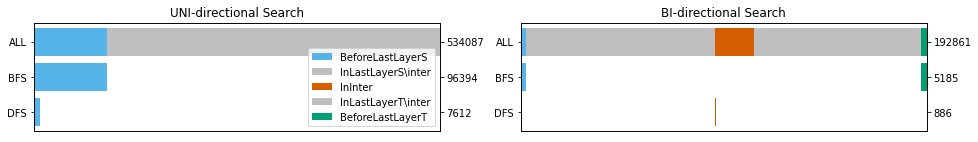

In [4]:

fig, axs = plt.subplots(1,2,figsize=(16, 2))

for dir, group in df.groupby('DIRECTION'):
    ax = axs[1] if dir=='BI' else axs[0]
    data= group.sum()

    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, data[allEdges].sum())

    # total space
    start = {}
    offset = 0
    for cat in allEdges:
        start[cat] = offset
        ax.barh('ALL', data[cat], left=start[cat], label=cat[5:], color=colors[cat[5:]])
        offset += data[cat]

    # bfs search space
    for cat in bfsEdges:
        ax.barh('BFS', data[cat], left=start[cat], color=colors[cat[5:]])

    # dfs search space
    for cat in dfsEdges:
        ax.barh('DFS', data[cat], left=start['e'+cat[4:]], color=colors[cat[8:]])

    ax2 = ax.twinx()
    ax2.set_yticks(ax.get_yticks())
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticklabels(f'{data[cats].sum()//num_pairs}' for cats in [allEdges, bfsEdges, dfsEdges])
    
    ax.set_title(f'{dir}-directional Search')

        
axs[0].legend(loc='lower right')
plt.savefig('eval_space_total.pdf', bbox_inches='tight')
plt.show()

In [5]:
# aggregate totals
numPairs = len(df.groupby(['S','T']))
totals = {'allNodes': 70068*numPairs, 'allEdges': 358647*2*numPairs}
for dir, dir_data in df.groupby('DIRECTION'):
    runs = dir_data.groupby(['S','T'])
    agg = runs.sum().sum()
    totals[dir+'bfsEdges'] = agg[bfsEdges].sum()
    totals[dir+'dfsEdges'] = agg[dfsEdges].sum()
    numBFS = len(dir_data)
    numDFS = len(dir_data)-len(runs)
    print('Direction  ', dir)
    print('pairs      ', len(runs))
    print('avg dist   ', runs['distOfSink'].first().mean())
    print('avg SDEG   ', runs.SDEG.first().mean())
    print('avg TDEG   ', runs.TDEG.first().mean())
    print('avg rounds ', runs.ROUND.max().add(1).mean())
    print('avg flow/R ', dir_data.flow.sum() / runs.ROUND.max().sum())
    print('avg BFS    ', totals[dir+'bfsEdges']//numBFS)
    print('avg DFS    ', totals[dir+'dfsEdges']//numDFS)
    print()
    
pairs = df[df.DIRECTION=='BI'].groupby(['S','T']).max()
print('trivial    ', len(pairs[pairs[['SDEG','TDEG']].min(axis=1) == pairs.flowBefore]))
print()
print('UNI / ALL')
for trav in ['bfs', 'dfs']:
    print(f'UNI-{trav} looks at', 
          '%.5f' % (totals[f'UNI{trav}Edges'] / totals[f'allEdges']), 
          f'times all edges')

print('UNI / BI')
for trav in ['bfs', 'dfs']:
    print(f'UNI-{trav} looks at', 
          '%.2f' % (totals[f'UNI{trav}Edges'] / totals[f'BI{trav}Edges']), 
          f'times BI-{trav} edges')

Direction   BI
pairs       70067
avg dist    1.7824653545891789
avg SDEG    10.234247220517505
avg TDEG    1491.6308390540482
avg rounds  2.7607861047283313
avg flow/R  5.5552835709596105
avg BFS     1878
avg DFS     503

Direction   UNI
pairs       70067
avg dist    1.7824653545891789
avg SDEG    10.234247220517505
avg TDEG    1491.6308390540482
avg rounds  2.7607861047283313
avg flow/R  5.5552835709596105
avg BFS     34915
avg DFS     4323

trivial     56087

UNI / ALL
UNI-bfs looks at 0.13439 times all edges
UNI-dfs looks at 0.01061 times all edges
UNI / BI
UNI-bfs looks at 18.59 times BI-bfs edges
UNI-dfs looks at 8.59 times BI-dfs edges
